### Part 2 (start in class)

First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- But check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. To start with, feel free to tweak the hyperparameters manually. But, of course, a publication-quality result will require a cross-validation analysis.

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.
- Think about the pdf of these data in $z$.
- Using your GPR fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 

In [1]:

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, ConstantKernel
from sklearn.model_selection import KFold
import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.integrate import quad
from astropy.constants import c
from scipy.optimize import curve_fit
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from astroML.datasets import generate_mu_z
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
import seaborn as sns
import tqdm 
from sklearn.model_selection import learning_curve


/Users/riccardobosonidemartini/Documents/.venv311/lib/python3.11/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


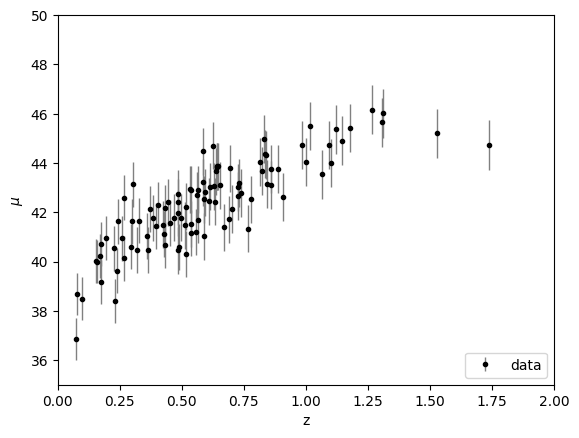

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) # YOU CANNOT CHANGE THIS

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

## GPR

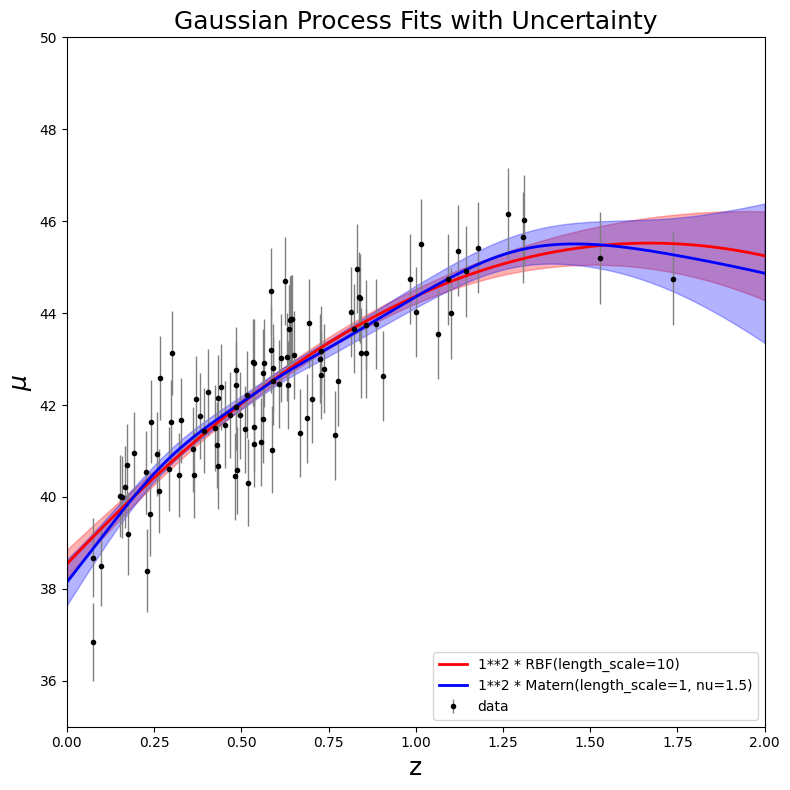

In [3]:
alpha = dmu ** 2  # errors from std to variance to be included in the fit
z_fit = np.linspace(0, 2, 1000)

kernels = [
    ConstantKernel(1.0) * RBF(length_scale=10), #the ConstantKernel multiplies the RBF kernel, controlling the overall vertical scale (amplitude) of the covariance function -how “strongly” two points are correlated at maximum similarity.
    ConstantKernel(1.0) * Matern(length_scale=1.0, nu=1.5), #generalization of the RBF (squared exponential) kernel that introduces a smoothness parameter 
    
]

plt.figure(figsize=(8, 8))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')

colors = ['red', 'blue']

for kernel, c in zip(kernels, colors):
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha)
    gp.fit(z_sample.reshape(-1, 1), mu_sample)
    mu_pred, mu_std = gp.predict(z_fit.reshape(-1, 1), return_std=True)
    
    # Plot the mean prediction
    plt.plot(z_fit, mu_pred, label=f'{kernel}', color=c, linewidth=2)
    
    # Add 1-sigma uncertainty band
    plt.fill_between(z_fit, mu_pred - mu_std, mu_pred + mu_std, 
                     color=c, alpha=0.3)

plt.xlabel("z", fontsize=18)
plt.ylabel("$\mu$", fontsize=18)
plt.legend(loc='lower right', fontsize=10)
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title('Gaussian Process Fits with Uncertainty', fontsize=18)
plt.tight_layout()
plt.show()




**Gaussian Process (GP) Regression** is a non-parametric, probabilistic approach to regression. Unlike polynomial regression where you choose a specific functional form (linear, quadratic, etc.), GP regression:

- **Doesn't assume a specific functional form** (no need to choose polynomial degree!)
- **Provides uncertainty estimates** automatically
- **Uses kernel functions** to define how similar nearby points should be
- **Is fully Bayesian** - gives you a distribution over possible functions



**Components:**
- `ConstantKernel(1.0)`: Overall amplitude/scale of the function
- `RBF(length_scale=10)`: Radial Basis Function (also called "Squared Exponential")
  - **length_scale=10**: How far you need to move in z before the function values become uncorrelated
  - Large length_scale → smooth, slowly varying functions
  - Small length_scale → wiggly, rapidly varying functions

**RBF characteristics:**
- Produces **infinitely smooth** functions
- Points close together are strongly correlated
- Correlation decreases exponentially with distance

#### Kernel 2: Matérn
```python
ConstantKernel(1.0) * Matern(length_scale=1.0, nu=1.5)
```

**Components:**
- `ConstantKernel(1.0)`: Overall amplitude
- `Matern(length_scale=1.0, nu=1.5)`: Matérn kernel with smoothness parameter ν
  - **length_scale=1.0**: Smaller than RBF → allows more local variation
  - **nu=1.5**: Controls smoothness
    - ν = 0.5 → very rough (equivalent to exponential kernel)
    - ν = 1.5 → once differentiable (moderate smoothness)
    - ν = 2.5 → twice differentiable (smoother)
    - ν → ∞ → approaches RBF (infinitely smooth)

**Matérn characteristics:**
- More flexible than RBF
- Can represent functions that aren't infinitely smooth
- Better for real-world data that may have some roughness




## Kernel Comparison

| Kernel | Length Scale | Smoothness | Best For |
|--------|--------------|------------|----------|
| RBF | 10 (large) | Infinitely smooth | Smooth cosmological curves |
| Matérn (ν=1.5) | 1.0 (small) | Once differentiable | More flexible, can capture local features |

## Why Use Gaussian Processes?

 Advantages:
1. **No need to choose polynomial degree** - the kernel handles complexity automatically
2. **Automatic uncertainty quantification** - you get error bars for free
3. **Incorporates measurement uncertainties** - uses `alpha` parameter
4. **Flexible** - can represent a wide variety of functions
5. **Regularization built-in** - naturally avoids overfitting through the prior

Disadvantages:
1. **Computationally expensive** for large datasets (scales as O(n³))
2. **Kernel choice matters** - need to pick appropriate kernel
3. **Less interpretable** than parametric models (no simple equation)


The GP approach is particularly powerful here because:
- You don't need to assume a specific cosmological model
- It naturally handles your measurement uncertainties (`dmu`)
- It provides uncertainty estimates on the interpolated curve
- It can reveal features in the data without overfitting

---

Instead of asking "what degree polynomial?", GP regression asks "how smooth should the function be?" and "how far do nearby points influence each other?" - a more natural way to think about the problem!

## K-fold Cross Validation on lenght-scale and Constant Kernel Amplitude (RBF kernel)

In [4]:
#two hyperpar to tune: the costant in front and the lenght scale
constants = np.geomspace(0.1, 100, 20)
scales = np.linspace(1, 100, 40)

crossval_err = []
kf = KFold(n_splits=5, shuffle=True, random_state=8)

for c in constants:
    for ls in scales:
        fold_errors = []
        
        for train_idx, val_idx in kf.split(z_sample):
            z_train, z_val = z_sample[train_idx], z_sample[val_idx]
            mu_train, mu_val = mu_sample[train_idx], mu_sample[val_idx]
            dmu_train, dmu_val = dmu[train_idx], dmu[val_idx]
            
            kernel = ConstantKernel(c) * RBF(length_scale=ls)
            gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu_train**2)
            gp.fit(z_train.reshape(-1, 1), mu_train)
            
            mu_pred, mu_std = gp.predict(z_val.reshape(-1, 1), return_std=True)
            
            error = np.sqrt(np.mean((mu_pred - mu_val) ** 2))
            fold_errors.append(error)
        
        crossval_err.append((c, ls, np.mean(fold_errors)))
        
best_kernel_params = min(crossval_err, key=lambda x: x[2])
print(f"Best kernel parameters: Constant {best_kernel_params[0]}, Length Scale {best_kernel_params[1]}, Error {best_kernel_params[2]:.4f} ")


Best kernel parameters: Constant 3.79269019073225, Length Scale 1.0, Error 0.9331 




1. Constant Kernel Amplitude (`c`):\
**Range**: 0.1 to 100 (20 values, logarithmically spaced)

- Controls the **overall variance/amplitude** of the GP function
- Larger values → bigger fluctuations in μ(z)
- Uses `geomspace` because amplitude often spans orders of magnitude

2. RBF Length Scale (`ls`):\
**Range**: 1 to 100 (40 values, linearly spaced)

- Controls how **smooth** the function is
- **Small length scale** → wiggly, captures fine details
- **Large length scale** → smooth, captures broad trends
- Uses `linspace` for even sampling\

3. The Cross-Validation Strategy:\

- Splits data into 5 equal parts
- Trains on 4 parts, validates on 1 part
- Repeats 5 times so each part is used for validation once
- Averages the errors across all 5 folds


-----------------------

This creates a 2D grid: 20 constants × 40 length scales = 800 combinations

- Cross-Validation for Each Combination
```python
for train_idx, val_idx in kf.split(z_sample):
```

For each hyperparameter pair (c, ls):

**Step 1: Split the data**
```python
z_train, z_val = z_sample[train_idx], z_sample[val_idx]
mu_train, mu_val = mu_sample[train_idx], mu_sample[val_idx]
dmu_train, dmu_val = dmu[train_idx], dmu[val_idx]
```
- 80% of data for training
- 20% for validation
- Repeat 5 times with different splits

**Step 2: Create and fit GP**
```python
kernel = ConstantKernel(c) * RBF(length_scale=ls)
gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu_train**2)
gp.fit(z_train.reshape(-1, 1), mu_train)
```
- Build kernel with current hyperparameters
- Include measurement uncertainties (`alpha=dmu_train**2`)
- Train on training fold

**Step 3: Evaluate on validation fold**
```python
mu_pred, mu_std = gp.predict(z_val.reshape(-1, 1), return_std=True)
error = np.sqrt(np.mean((mu_pred - mu_val) ** 2))
fold_errors.append(error)
```
- Predict on unseen validation data
- Calculate **RMSE** (Root Mean Square Error)
- Store error for this fold

**Step 4: Average across folds**
```python
crossval_err.append((c, ls, np.mean(fold_errors)))
```
- Average the 5 fold errors
- Store tuple: (constant, length_scale, avg_error)


```python
best_kernel_params = min(crossval_err, key=lambda x: x[2])
```

**What this does:**
- `crossval_err` contains 800 tuples: [(c₁, ls₁, error₁), (c₂, ls₂, error₂), ...]
- `key=lambda x: x[2]` tells `min()` to compare by the 3rd element (the error)
- Returns the tuple with the **smallest average cross-validation error**

**Result**: `best_kernel_params = (optimal_c, optimal_ls, min_error)`

- What You're Optimizing:
- **Too small constant** → underfits (can't explain variance in data)
- **Too large constant** → overfits (too much flexibility)
- **Too small length scale** → overfits (too wiggly, fits noise)
- **Too large length scale** → underfits (too smooth, misses features)


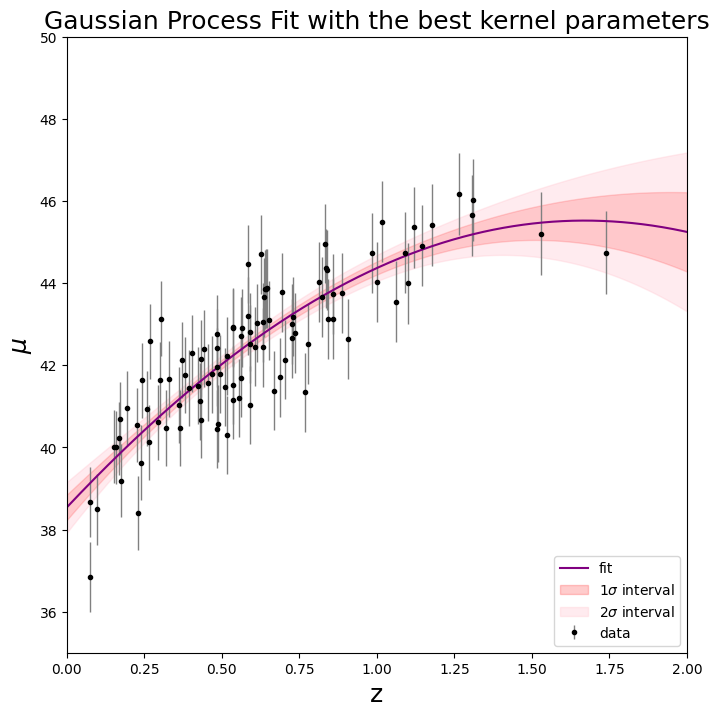

In [10]:
kernel = ConstantKernel(best_kernel_params[0]) * RBF(length_scale=best_kernel_params[1]) #defining a composite kernel

gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2)
gp.fit(z_sample.reshape(-1, 1), mu_sample)
mu_pred, mu_std = gp.predict(z_fit.reshape(-1, 1), return_std=True)

plt.figure(figsize=(8, 8))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(z_fit, mu_pred, label=f'fit', color='purple')
plt.fill_between(z_fit, mu_pred - mu_std, mu_pred + mu_std, alpha=0.2, label='1$\sigma$ interval', color='red')
plt.fill_between(z_fit, mu_pred - 2 * mu_std, mu_pred + 2 * mu_std, alpha=0.3, label='2$\sigma$ interval', color='pink')

plt.xlabel("z",  fontsize=18)
plt.ylabel("$\mu$",  fontsize=18)
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title(f'Gaussian Process Fit with the best kernel parameters',  fontsize=18)
plt.show()

## K-fold cross validation on Matern

In [12]:
constants = np.geomspace(0.1, 100, 20)
np.linspace(0.1, 50, 35)
nu = [0.5,1.5,2.5] #smoothness of the function -> the higher the smoother

crossval_err = []
kf = KFold(n_splits=5, shuffle=True, random_state=8)

for c in constants:
    for ls in scales:
        for n in nu:
                
            fold_errors = []
            
            for train_idx, val_idx in kf.split(z_sample):
                z_train, z_val = z_sample[train_idx], z_sample[val_idx]
                mu_train, mu_val = mu_sample[train_idx], mu_sample[val_idx]
                dmu_train, dmu_val = dmu[train_idx], dmu[val_idx]
                
                kernel = ConstantKernel(c) * Matern(length_scale=ls, nu=n)
                gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu_train**2)
                gp.fit(z_train.reshape(-1, 1), mu_train)
                
                mu_pred, mu_std = gp.predict(z_val.reshape(-1, 1), return_std=True)
                
                error = np.sqrt(np.mean((mu_pred - mu_val) ** 2))
                fold_errors.append(error)
            
            mean_error = np.mean(fold_errors)    
            std_error = np.std(fold_errors) 
            crossval_err.append((c, ls, n, mean_error, std_error))


best_kernel_params_2 = min(crossval_err, key=lambda x: x[3]) 
print(f"Best kernel parameters: Constant {best_kernel_params_2[0]}, Length Scale {best_kernel_params_2[1]}, Nu {best_kernel_params_2[2]:.4f}, Error {best_kernel_params_2[3]:.4f} ± {best_kernel_params_2[4]:.4f}")


Best kernel parameters: Constant 23.357214690901213, Length Scale 77.15384615384615, Nu 0.5000, Error 0.9142 ± 0.1154


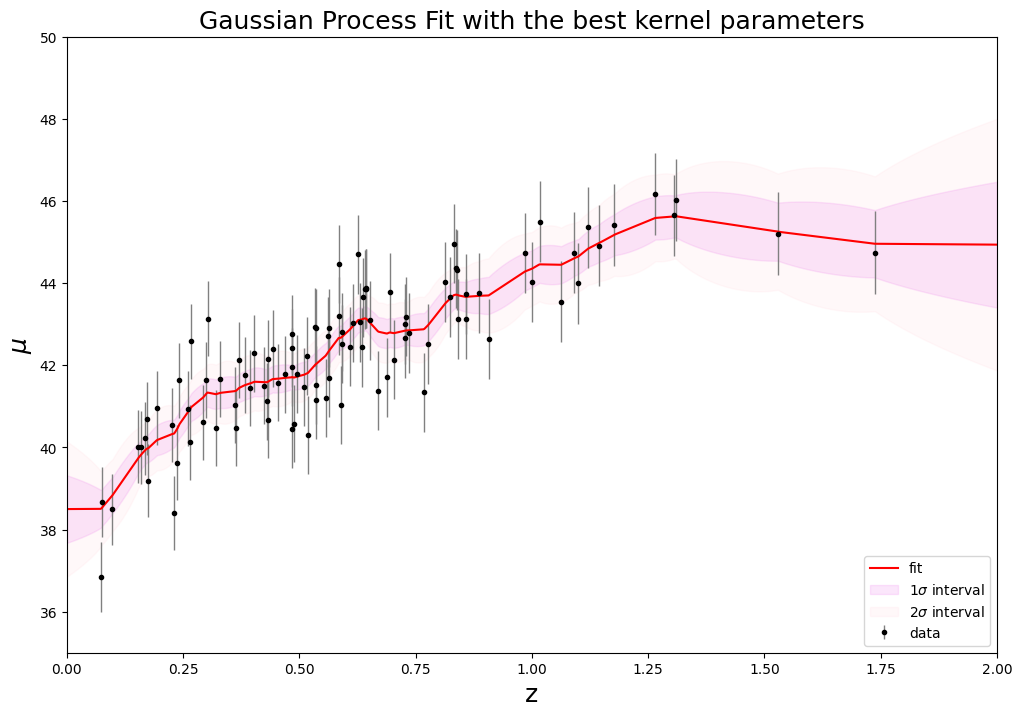


[CV] END alpha=[0.84387183 0.91812087 0.89001003 0.94522717 0.94422381 0.86154897
 0.86230499 0.94838417 0.9933467  0.9646779  0.87701523 0.89976228
 0.92772472 0.93248803 0.87910942 0.90886653 0.90007965 0.74796941
 0.94290888 0.96641079 0.87820976 0.91709206 0.80479835 0.87887073
 0.98216481 0.92265029 0.8835475  0.94586178 0.86985438 0.90990902
 0.96297778 0.88976599 0.94843792 0.83090193 0.93109673 0.93114927
 0.85028275 0.97913394 0.89070147 0.97400271 0.7962183  0.84206808
 0.78788603 0.92635379 0.91392593 0.90465689 0.78478839 0.9089023
 0.87214385 0.90006197 0.82033163 0.91583891 0.90958362 0.72753792
 0.91740524 0.97488255 0.94620146 1.02438615 0.99370304 0.94647514
 0.86399823 0.91855219 0.89626639 0.84488705 0.88111247 0.79245055
 0.8921843  1.01044616 0.82456879 0.82300352 0.93684146 0.91281498
 0.89527413 0.81855684 0.85259287 0.97119502 0.88669278 0.90504074
 0.72518962 0.86689404 0.88987903 0.91659546 0.97685316 0.91867826
 0.93138181 0.83270862 0.93814442 0.95430226 0.

In [16]:
kernel = ConstantKernel(best_kernel_params_2[0]) * Matern(length_scale=best_kernel_params_2[1], nu=best_kernel_params_2[2])

gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2)
gp.fit(z_sample.reshape(-1, 1), mu_sample)
mu_pred, mu_std = gp.predict(z_fit.reshape(-1, 1), return_std=True)


plt.figure(figsize=(12, 8))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(z_fit, mu_pred, label=f'fit', color='red')
plt.fill_between(z_fit, mu_pred - mu_std, mu_pred + mu_std, alpha=0.2, label='1$\sigma$ interval', color='violet')
plt.fill_between(z_fit, mu_pred - 2 * mu_std, mu_pred + 2 * mu_std, alpha=0.1, label='2$\sigma$ interval', color='pink')

plt.xlabel("z",  fontsize=18)
plt.ylabel("$\mu$",  fontsize=18)
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title(f'Gaussian Process Fit with the best kernel parameters',  fontsize=18)
plt.show()

In [10]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

"""
Generate synthetic supernova data from Gaussian Process fit
that respects the statistical properties of the original data
"""
kernel = ConstantKernel(best_kernel_params[0]) * RBF(length_scale=best_kernel_params[1])
gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2)
gp.fit(z_sample.reshape(-1, 1), mu_sample)

# Sample multiple realizations from the GP posterior
n_samples = 5  # Number of synthetic datasets to generate

# Get GP predictions and full covariance matrix at original z positions
mu_pred_original, cov_matrix = gp.predict(z_sample.reshape(-1, 1), return_cov=True)

# The covariance already includes the noise from alpha parameter in the fit
# mu_pred_original → GP posterior mean vector at each z_sample point.
# Generate synthetic data by sampling from multivariate normal
synthetic_datasets = np.random.multivariate_normal(mu_pred_original, cov_matrix, size=n_samples) #drawing random realizations (samples) from the posterior Gaussian distribution

print(f"\nGenerated {n_samples} synthetic datasets")
print(f"Each has {len(z_sample)} measurements at the same redshifts as original data")
print(f"\nOriginal data statistics:")
print(f"  Mean μ: {mu_sample.mean():.3f}")
print(f"  Std μ:  {mu_sample.std():.3f}")


print(f"\nSynthetic data statistics (example from first sample):")
print(f"  Mean μ: {synthetic_datasets[0].mean():.3f}")
print(f"  Std μ:  {synthetic_datasets[0].std():.3f}")



Generated 5 synthetic datasets
Each has 100 measurements at the same redshifts as original data

Original data statistics:
  Mean μ: 42.380
  Std μ:  1.788

Synthetic data statistics (example from first sample):
  Mean μ: 42.409
  Std μ:  1.690


the end of this process, the synthetic_datasets array represents five different models of your dataset, each generated using the information learned by the Gaussian Process fit.\
your Gaussian Process Regressor (GPR) has learned:\
	1.	The underlying functional relationship between your input (z_sample) and output (mu_sample).
→ This is represented by the posterior mean function μ_pred_original.\
	2.	The uncertainty structure of that relationship — how confident the GP is about each region, and how correlated neighboring points are.
→ This is captured in the covariance matrix cov_matrix.


### Part 3 (for the exam)



We now have a suite of **data-driven** predictive models for our supernova dataset (from polynomials to GPR). That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.


For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM. We can do a **parametric** fit (and hopehully by now the difference between "parametric" and "data driven" fit is clear in your head)

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). The answer is:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$

- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data, however you want to do it, using tecniques we've seen throughout the course. Some ideas:
    - Set up a Bayesian framework and use MCMC. 
    - Set up a fully-connected neural network (see end of the class).

- What are the measured value of $H_0$ and $\Omega_m$. What's they errors? Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)



if $\Omega_K = 0 $ then $\Omega_\Lambda = 1- \Omega_m$ \
so the 1st eq become :\
$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z'^3)+(1-\Omega_m)}} \right) $$\
Run nested sampling to fit and compare:

In [22]:
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
import dynesty
import corner
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
from scipy.stats import 

cosmology = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725) #defining a cosmological model, flat ΛCDM (Lambda Cold Dark Matter) model



def mu_cosmology(z, H0 ,om):
    cosmology = FlatLambdaCDM(H0=H0, Om0=om, Tcmb0=2.725) #This returns the distance modulus
    return cosmology.distmod(z).value

def loglike(params): 
    H0, om = params
    if om > 0:
        mu = mu_cosmology(z_sample, H0, om)
        return np.sum(norm(loc=mu, scale=dmu).logpdf(mu_sample))
    if om < 0:
        return -np.inf
        
def nest_flat_prior(u, min_val, max_val): #Converts uniform samples u ∈ [0,1] to flat priors
    # `u` between 0 e 1 transform in space par
    return min_val + u * (max_val - min_val)

def prior_transform(u):
    H0 = nest_flat_prior(u[0], 35, 95)
    om  = nest_flat_prior(u[1], 0, 1)
    
    return [H0, om]

$\ln \mathcal{L} = \sum_i \ln \mathcal{N}(\mu_i^{obs} | \mu_i^{model}, \sigma_i)$

In [18]:
import dynesty

ndim = 2
sampler = dynesty.NestedSampler(loglike, prior_transform, ndim, nlive=500) 
sampler.run_nested()
sresults = sampler.results


631it [01:00, 27.07it/s, +500 | bound: 0 | nc: 1 | ncall: 13932 | eff(%): 15.865 | loglstar:   -inf < -132.814 <    inf | logz: -135.217 +/-  0.047 | dlogz:  0.001 >  0.509]

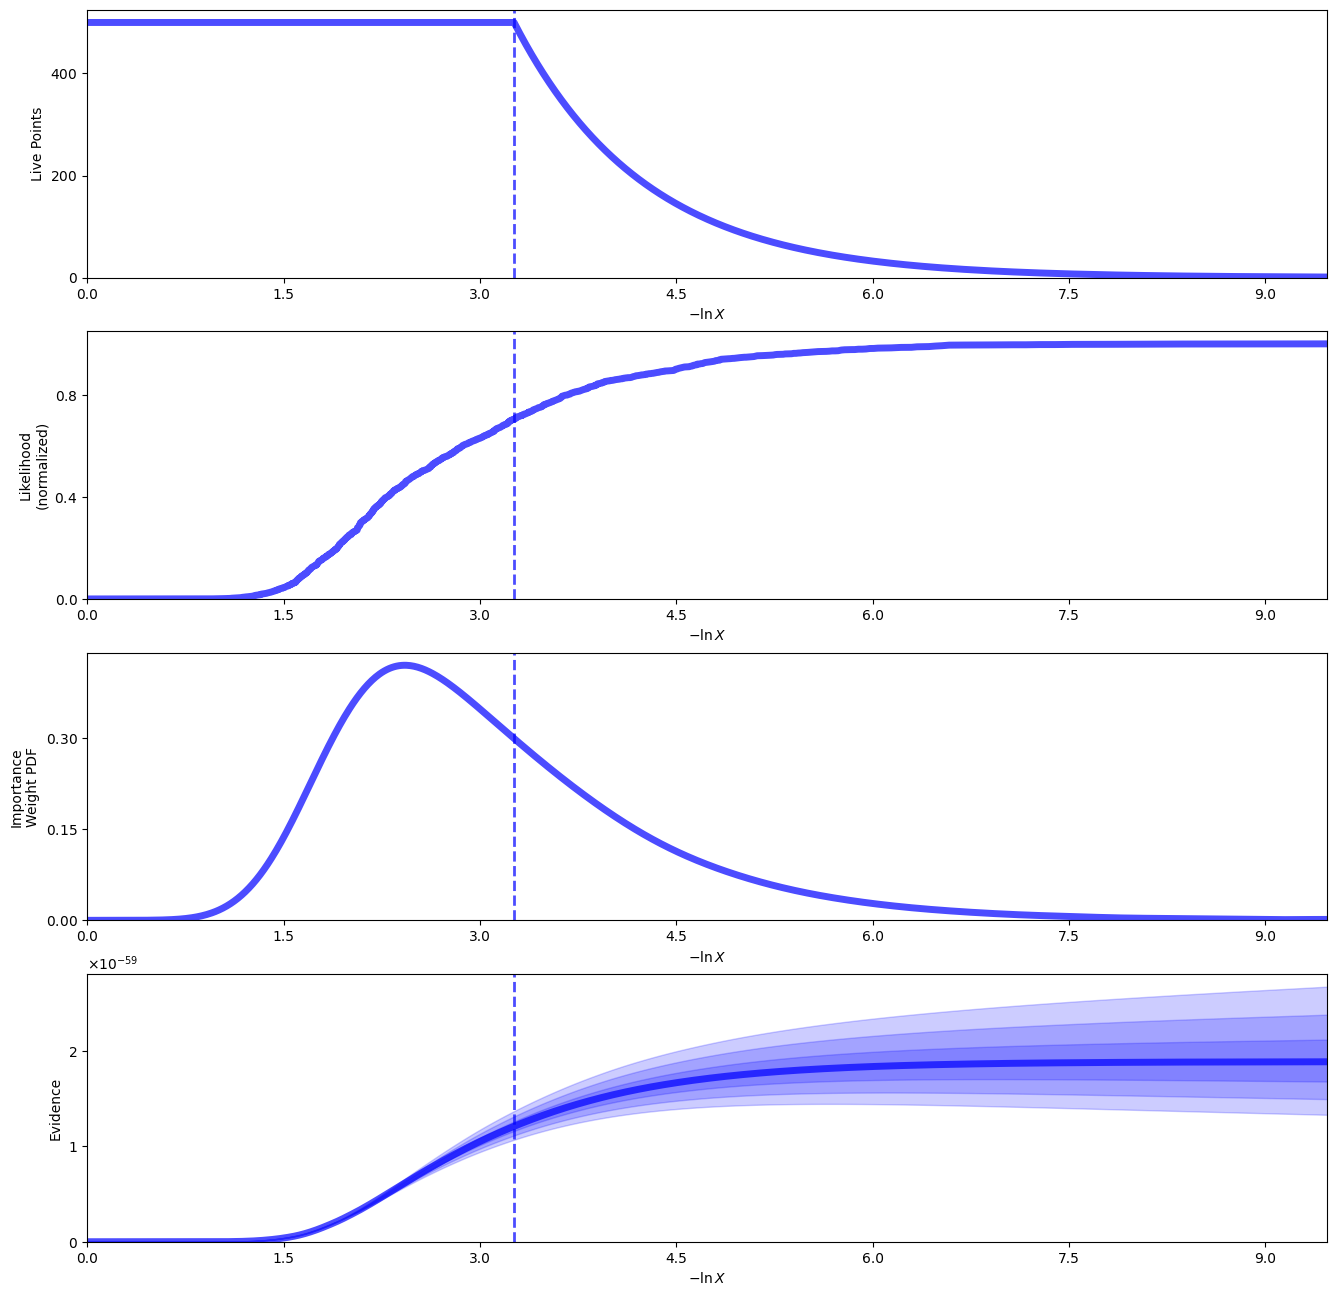

In [19]:
rfig, raxes = dyplot.runplot(sresults)

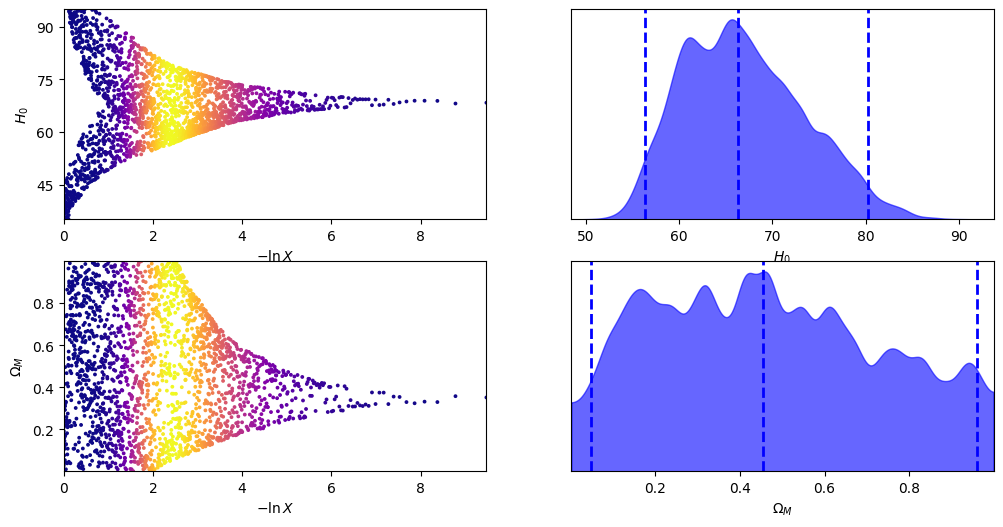

In [20]:
labels = [r'$H_0$', r'$\Omega_M$']
tfig, taxes = dyplot.traceplot(sresults, labels=labels)

/var/folders/dm/sy7c98fx7rl_tb_zs0mdpsj40000gn/T/ipykernel_62828/1618708505.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


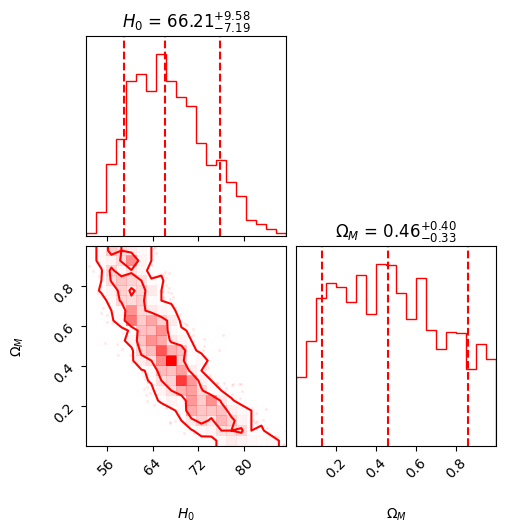

In [23]:
samples = sresults.samples  
weights = np.exp(sresults.logwt - sresults.logz[-1])

samples_equal = dyfunc.resample_equal(samples, weights)

fig = corner.corner(
    samples_equal,                      
    labels=labels,                        
    quantiles=[0.10, 0.5, 0.90],           
    show_titles=True,                      
    title_fmt=".2f",                       
    levels=(0.68, 0.95),                  
    plot_density=True,                                       
    color='red'                           
)

fig.show()

/Users/riccardobosonidemartini/Documents/.venv311/lib/python3.11/site-packages/astropy/cosmology/_src/flrw/base.py:1390: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


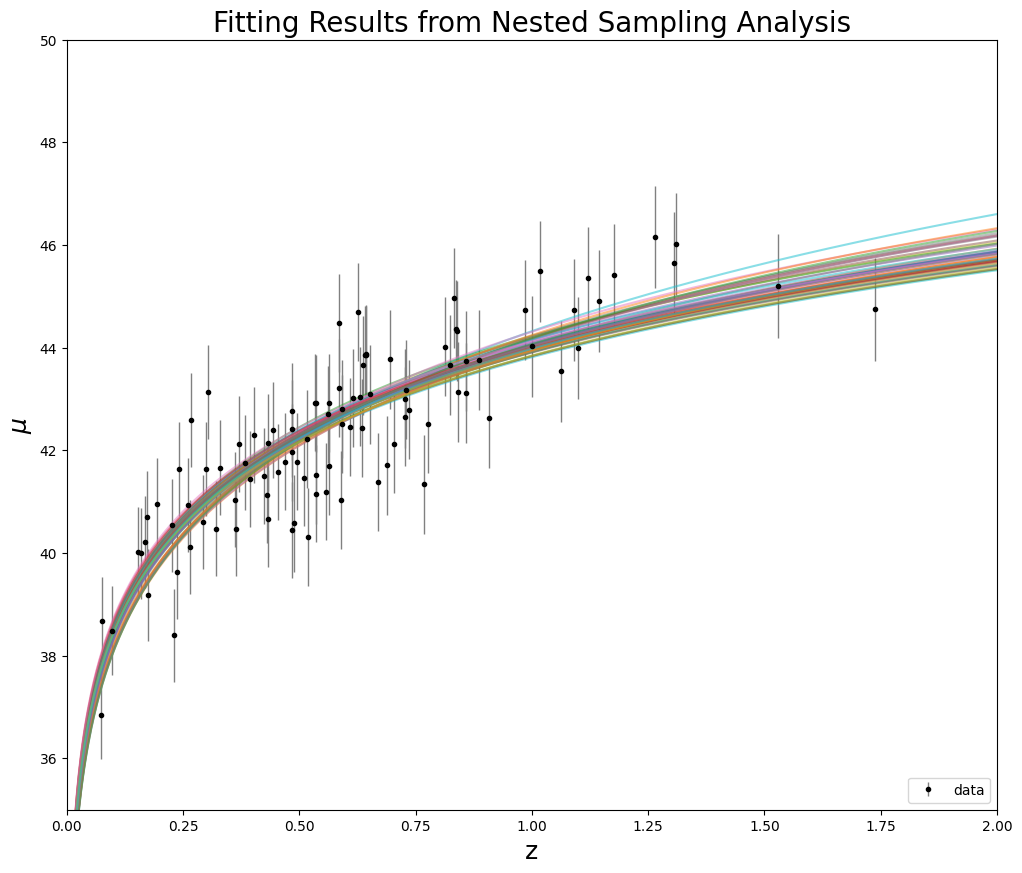

In [24]:
#plotting posterior predictive curves from a random subset of the nested sampling results
fig = plt.figure(figsize=(12, 10))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')

samples_batch = np.random.choice(np.arange(0, len(samples_equal)), size=50, replace=False)
chosen_samples= samples_equal[samples_batch]

for chosen_par in chosen_samples:
    H0, om = chosen_par
    ygrid =  mu_cosmology(z_fit, H0, om)
    plt.plot(z_fit, ygrid, alpha=0.5)
    
plt.xlabel("z",  fontsize=18)
plt.ylabel("$\mu$",  fontsize=18)
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title('Fitting Results from Nested Sampling Analysis', fontsize=20)
plt.show()

## No Dark Energy model


In [25]:
def loglike_new(params):
    H0 = params[0]
    om = 1 # Ωₘ = 1 
    mu = mu_cosmology(z_sample, H0, om)
    return np.sum(norm(loc=mu, scale=dmu).logpdf(mu_sample))

def prior_transform_new(u):
    H0 = nest_flat_prior(u[0], 35, 95)
    
    return [H0]

In [26]:
ndim_new = 1
sampler_new = dynesty.NestedSampler(loglike_new, prior_transform_new, ndim_new) 
sampler_new.run_nested()
sresults_new = sampler_new.results


568it [00:55, 28.30it/s, +500 | bound: 0 | nc: 1 | ncall: 12729 | eff(%): 16.911 | loglstar:   -inf < -133.531 <    inf | logz: -135.759 +/-  0.036 | dlogz:  0.001 >  0.509]

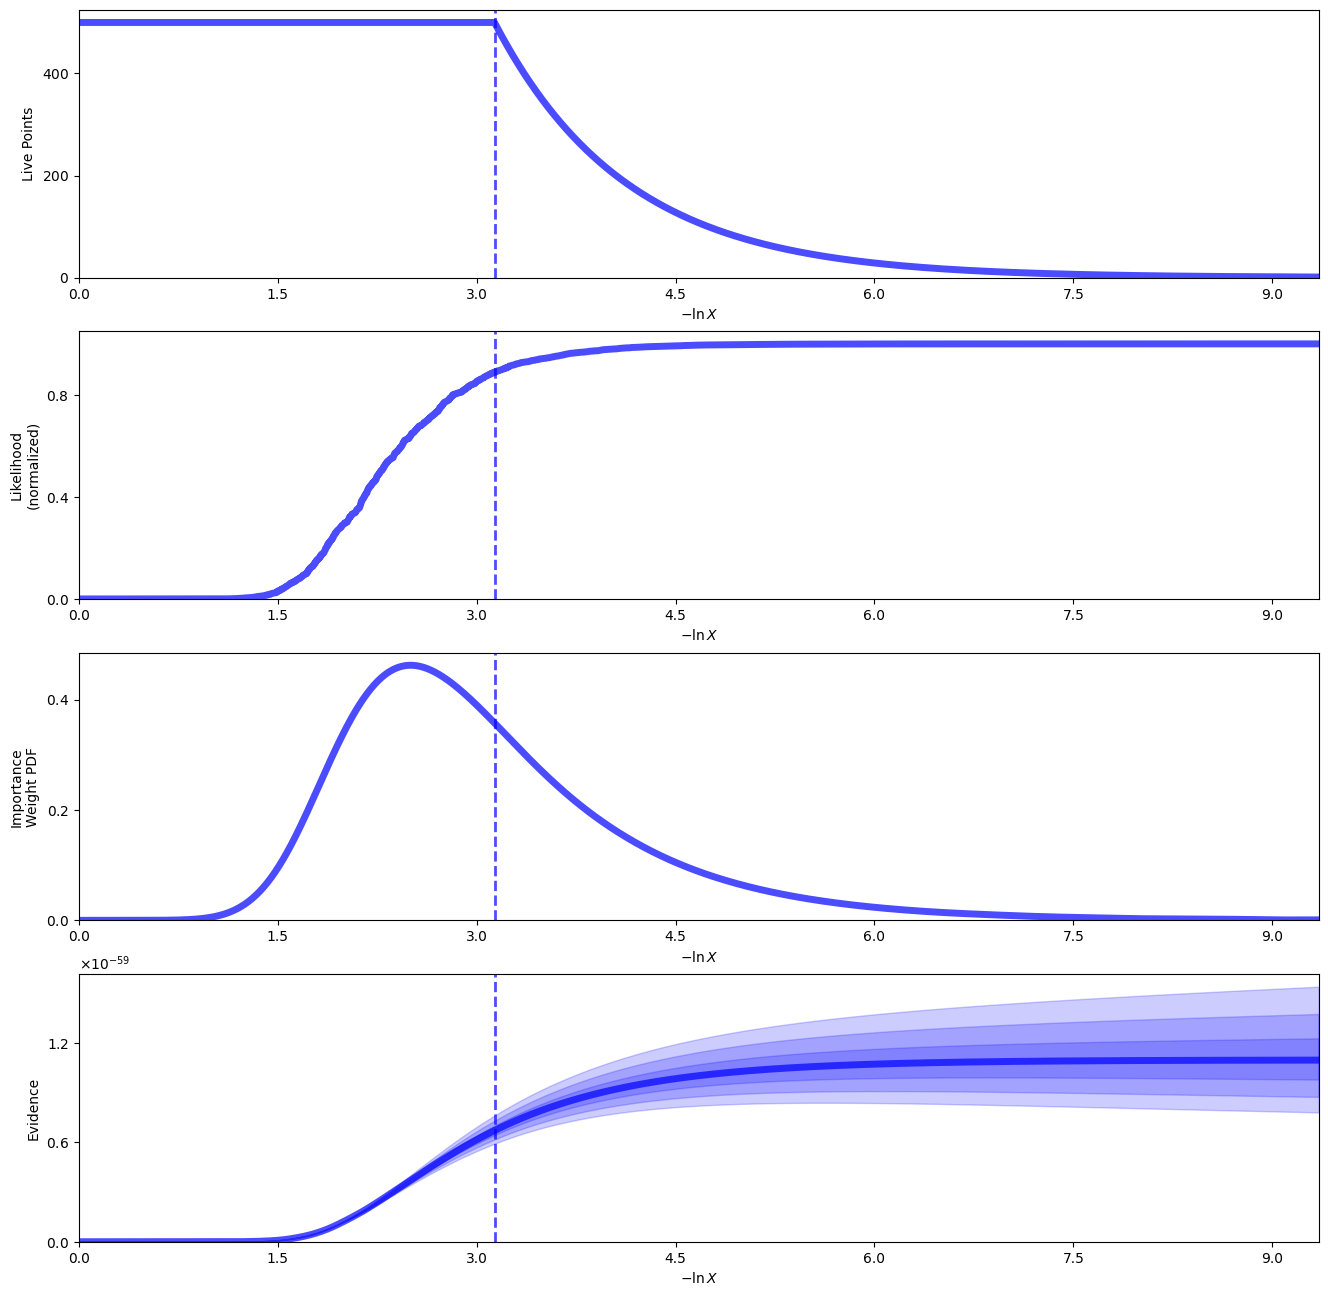

In [27]:
rfig, raxes = dyplot.runplot(sresults_new)


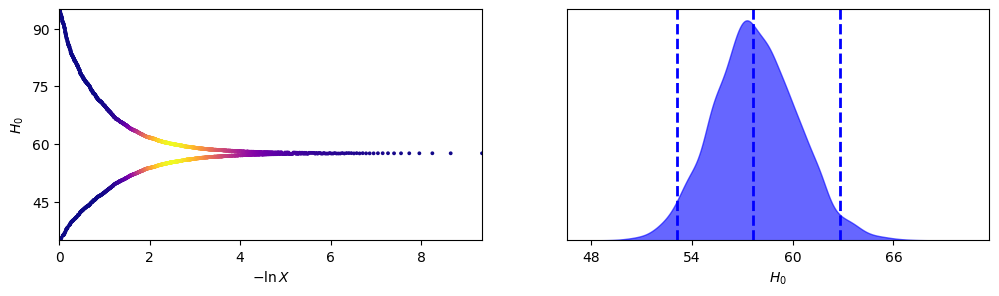

In [28]:
tfig, taxes = dyplot.traceplot(sresults_new, labels=[r'$H_0$'])

/var/folders/dm/sy7c98fx7rl_tb_zs0mdpsj40000gn/T/ipykernel_62828/1889191756.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


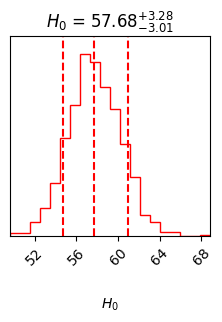

In [30]:
samples_new = sresults_new.samples  
weights_new = np.exp(sresults_new.logwt - sresults_new.logz[-1])

samples_equal_new = dyfunc.resample_equal(samples_new, weights_new)

fig = corner.corner(
    samples_equal_new,                      
    labels=[r'$H_0$'],                        
    quantiles=[0.10, 0.5, 0.90],           
    show_titles=True,                      
    title_fmt=".2f",                       
    levels=(0.68, 0.95),                  
    plot_density=True,                                       
    color='red'                           
)

fig.show()

/Users/riccardobosonidemartini/Documents/.venv311/lib/python3.11/site-packages/astropy/cosmology/_src/flrw/base.py:1390: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


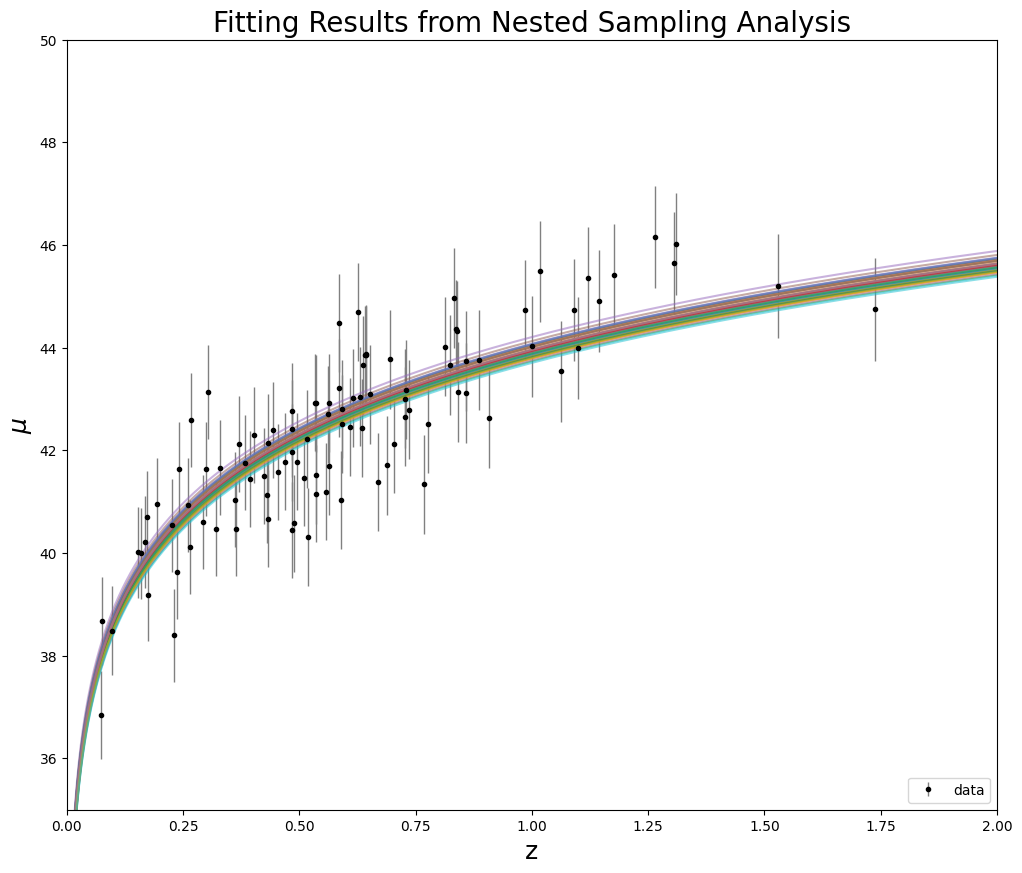

In [31]:
fig = plt.figure(figsize=(12, 10))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')

samples_batch_new = np.random.choice(np.arange(0, len(samples_equal_new)), size=50, replace=False)
chosen_samples_new= samples_equal_new[samples_batch_new]

for chosen_par in chosen_samples_new:
    H0 = chosen_par[0]
    ygrid =  mu_cosmology(z_fit, H0, 1)
    plt.plot(z_fit, ygrid, alpha=0.5)
    
plt.xlabel("z",  fontsize=18)
plt.ylabel("$\mu$",  fontsize=18)
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.title('Fitting Results from Nested Sampling Analysis', fontsize=20)
plt.show()

let's compare the 2 models looking at he evidences

In [32]:
evidence = np.exp(sresults.logz[-1]) #evidence, exp(log of the marginal likeli)
errev = sresults.logzerr[-1] * evidence #with propoag of error rule: σ_evidence = evidence × σ_logZ
print(f"Bayesian evidence of burst model {evidence} ± {errev} ")

evidence_no_de= np.exp(sresults_new.logz[-1]) 
errev_no_de = sresults_new.logzerr[-1] * evidence_no_de
print(f"Bayesian evidence of gaussian model {evidence_no_de} ± {errev_no_de}")

Bayesian evidence of burst model 1.8882902257200595e-59 ± 2.1962254575102076e-60 
Bayesian evidence of gaussian model 1.097881696062116e-59 ± 1.2430433911004077e-60


In [34]:
# evaluating the Bayes factor:

B_factor = evidence/evidence_no_de
err_B_factor = np.sqrt( errev**2 / evidence_no_de**2 + evidence**2 * errev_no_de**2 / evidence_no_de**2) #propagate the errors

print(f'The Bayes Factor (model with dark en. over model without) is {B_factor:.3f} ± {err_B_factor:.3f} so there is not a strong preference in favour of the first one ')


The Bayes Factor (model with dark en. over model without) is 1.720 ± 0.200 so there is not a strong preference in favour of the first one 
